In [46]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import cv2
import torch
import numpy 
import torchvision

In [49]:
import sys
sys.path.append("../../src/")
sys.path.append("../")
import model
from datasets import imagenet
import config
from aux.utils import obtain_features_map, load_imgs, zscore, extract_valid
from aux.visualization import visualize_features_map
from utils.visualizations.visualize import concat_imgs, preprocess_arrays
from torchvision import transforms                                                                                                                                        
from PIL import Image

In [50]:
num_class = 30
class_index = 950
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
reverse_mean = [-0.485, -0.456, -0.406]
reverse_std = [1/0.229, 1/0.224, 1/0.225]
train_transform = transforms.Compose([                                                                                                                                
    transforms.Resize((224, 224), interpolation=Image.BILINEAR),                                                                                              
    transforms.ToTensor(),                                                                                                                                            
    #transforms.Normalize(mean, std)                                                                                                                                   
       ])         
trainset = imagenet.ImageNet(root="/media/lincolnzjx/HardDisk/Datasets/", 
                             is_train=True, transform=train_transform)
trainset.set_data([class_index], num_class)
imgs_path = []                                                                                                                                                            
images = []
labels = []
for img, label, img_path in trainset:                                                                                                                                     
    images.append(img.unsqueeze(0))                                                                                                                                       
    labels.append(label)                                                                                                                                                  
    imgs_path.append(img_path)  

Len of new dataset is :30


In [5]:
cd ../

/home/lincolnzjx/Desktop/Interpretation/jupyter


In [6]:
cd ../

/home/lincolnzjx/Desktop/Interpretation


In [7]:
cd extra/

/home/lincolnzjx/Desktop/Interpretation/extra


In [8]:
cd tutorial/

/home/lincolnzjx/Desktop/Interpretation/extra/tutorial


In [9]:
import utilss

In [10]:
# img = numpy.array(cv2.imread('castle.jpg'))[...,::-1]/255.0
img = images[0][0].permute((1,2,0)).numpy()

In [11]:

mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1,-1,1,1)
std  = torch.Tensor([0.229, 0.224, 0.225]).reshape(1,-1,1,1)

X = (torch.FloatTensor(img[numpy.newaxis].transpose([0,3,1,2])*1) - mean) / std

model = torchvision.models.vgg16(pretrained=True); model.eval()
layers = list(model._modules['features']) + utilss.toconv(list(model._modules['classifier']))

# L = len(layers)
L = 2

In [12]:
A = [X]+[None]*L
for l in range(L): A[l+1] = layers[l].forward(A[l])
    
scores = numpy.array(A[-1].data.view(-1))
ind = numpy.argsort(-scores)
# for i in ind[:10]:
#     print('%20s (%3d): %6.3f'%(utilss.imgclasses[i][:20],i,scores[i]))

In [13]:
layers[0].weight.shape

torch.Size([64, 3, 3, 3])

In [14]:
# T = torch.FloatTensor((1.0*(numpy.arange(1000)==483).reshape([1,1000,1,1])))
layers[1]
T = torch.zeros((3, 64, 224, 224))
T[:,16, :,:] = 1

R = [None]*L + [(A[-1]*T).data]

In [15]:
for l in range(1,L)[::-1]:
    
    A[l] = (A[l].data).requires_grad_(True)

    if isinstance(layers[l],torch.nn.MaxPool2d): layers[l] = torch.nn.AvgPool2d(2)

    if isinstance(layers[l],torch.nn.Conv2d) or isinstance(layers[l],torch.nn.AvgPool2d):

        if l <= 16:       rho = lambda p: p + 0.25*p.clamp(min=0); incr = lambda z: z+1e-9
        if 17 <= l <= 30: rho = lambda p: p;                       incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
        if l >= 31:       rho = lambda p: p;                       incr = lambda z: z+1e-9

        z = incr(utilss.newlayer(layers[l],rho).forward(A[l]))  # step 1
        s = (R[l+1]/z).data                                    # step 2
        (z*s).sum().backward(); c = A[l].grad                  # step 3
        R[l] = (A[l]*c).data                                   # step 4
        
    else:
        
        R[l] = R[l+1]

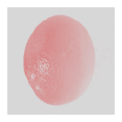

In [21]:
# for i,l in enumerate([31,21,11,1]):
#     utils.heatmap(numpy.array(R[l][0]).sum(axis=0),0.5*i+1.5,0.5*i+1.5)
for i,l in enumerate([1]):
    utilss.heatmap(numpy.array(R[l][0]).sum(axis=0),0.5*i+1.5,0.5*i+1.5)

In [17]:
A[0] = (A[0].data).requires_grad_(True)

lb = (A[0].data*0+(0-mean)/std).requires_grad_(True)
hb = (A[0].data*0+(1-mean)/std).requires_grad_(True)

z = layers[0].forward(A[0]) + 1e-9                                     # step 1 (a)
z -= utilss.newlayer(layers[0],lambda p: p.clamp(min=0)).forward(lb)    # step 1 (b)
z -= utilss.newlayer(layers[0],lambda p: p.clamp(max=0)).forward(hb)    # step 1 (c)
s = (R[1]/z).data                                                      # step 2
(z*s).sum().backward(); c,cp,cm = A[0].grad,lb.grad,hb.grad            # step 3
R[0] = (A[0]*c+lb*cp+hb*cm).data                                       # step 4

In [25]:
R[0][0].sum(axis=0).shape

torch.Size([224, 224])

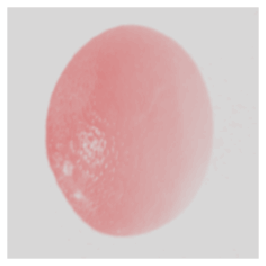

In [18]:
utilss.heatmap(numpy.array(R[0][0]).sum(axis=0),3.5,3.5)

In [38]:
example = np.array(R[0][0]).transpose((1,2,0))

In [30]:
import matplotlib

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


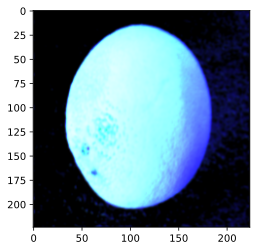

In [42]:
matplotlib.pyplot.imshow(example, vmin=0, vmax=255)

In [45]:
np.max(np.abs(example) ** 3)

215.24971

In [41]:
np.min(example)

0.0